# Import modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
from datetime import datetime
from datetime import timedelta
from module_io import read_NL_SAM, read_WL_map, get_WL_map
from module_WLmetric import compute_SMB, compute_WLscore, compute_min_dist
import os

# User inputs

### NL params

In [2]:
NL_date = datetime(2018,10,1,0,0,0) #UTC
NL_fullpath = os.path.join("..","data","NL","NeutralLineMap_Badman_AGONG_2018-10-01_2.5Rs.csv")

#NL_date = datetime(2022,1,16,0,0,0) #UTC
#NL_fullpath = "" #if left empty, use an analytical description

### WL metric params

In [3]:
WL_path = os.path.join("..","data","WL") #local path to store the WL maps

#WL_date = datetime(2018,10,1,0,0,0) #if left empty then WL_date=NL_date
WL_date = []

flg_download = False

smoothing_factor = 20 #Width of gaussian filter used to smooth the SMB line
norm_mode = 'fixed' #Mode of normalization of the WL metric: 'fixed' or 'SB_thickness'

### Plot options

In [4]:
make_plot = True
plot_lines= False
plot_fills= True

# Get NL

In [5]:
if NL_fullpath=="": #Make fake NL
    NL_phi_edges = np.arange(0,361)
    NL_th_edges = 45*np.cos(np.pi/180*NL_phi_edges)
else:
    [NL_phi_edges,NL_th_edges] = read_NL_SAM(NL_fullpath)

# Get WL map

In [6]:
if not np.any(WL_date): WL_date=NL_date
if flg_download:
    WL_source = 'connect_tool'
else:
    WL_source = 'V1.1'

[WL_fullpath,WL_date] = get_WL_map(WL_date,WL_path,WL_source)
[WL_I,WL_pphi,WL_tth,WL_I_edges,WL_pphi_edges,WL_tth_edges] = read_WL_map(WL_fullpath,WL_source)

Local archive: the closest (in time) WL map available from input date: 2018-10-01T00:00:00 is: 2018-10-01 12:00:00


# Compute WL metric

### Compute SMB line

In [7]:
[SMB_phi_edges,SMB_th_edges] = compute_SMB(WL_I_edges,WL_pphi_edges,WL_tth_edges,smoothing_factor)

#Recompute new pixel centres values
SMB_phi = WL_pphi[0,:].flatten()
SMB_th = (SMB_th_edges[1:]+SMB_th_edges[0:-1])/2

### Compute angular separation between NL and SMB

In [8]:
#Form pair of points between NL and SMB
phi2 = np.tile(NL_phi_edges[:,np.newaxis],(1,np.size(SMB_phi_edges,0)))*np.pi/180
th2 = np.tile(NL_th_edges[:,np.newaxis],(1,np.size(SMB_phi_edges,0)))*np.pi/180
phi1 = np.tile(SMB_phi_edges[:,np.newaxis].T,(np.size(NL_phi_edges,0),1))*np.pi/180
th1 = np.tile(SMB_th_edges[:,np.newaxis].T,(np.size(NL_phi_edges,0),1))*np.pi/180

#Compute min distance of NL to each SMB point
[sigma_min,idx_min] = compute_min_dist(phi1,th1,phi2,th2)

#Normalization
match norm_mode:
    case 'fixed': #i.e. equivalent to a constant streamer belt thickness
        norm_val = 5*np.ones(np.shape(sigma_min)) #in deg
    case 'SB_thickness': #Compute real streamer belt thickness from WL map
        print("Cpmputation of the real streamer belt thickness is not implemented yet!! Switching to fixed mode: thick=5deg.")
        norm_val = 5*np.ones(np.shape(sigma_min)) #in deg
sigma_min/=norm_val

### Compute WL score

In [9]:
mean_val = np.mean(sigma_min)
err_val = np.std(sigma_min)
WL_score = compute_WLscore(sigma_min,mean_val,err_val)
WL_n = np.sum(1-np.isnan(sigma_min))
print("The WL metric gives a score of "+f'{WL_score:0.1f}'+"% over: "+f'{WL_n:d}'+' sample points!')

The WL metric gives a score of 43.4% over: 361 sample points!


# Plot NL / WL comparison

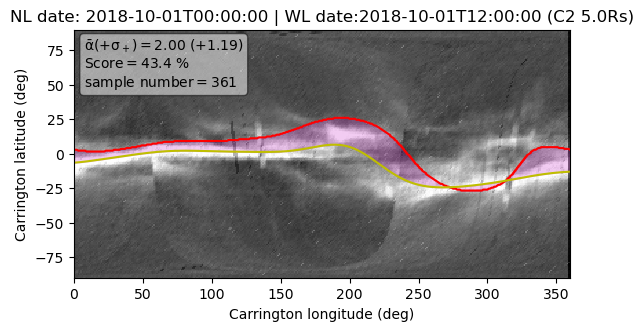

In [10]:
fig, ax = plt.subplots()

#ax.imshow(WL_I, cmap=plt.cm.gray, extent=[np.min(WL_phi), np.max(WL_phi), np.min(WL_th), np.max(WL_th)], aspect='equal', interpolation='none')
ax.pcolor(WL_pphi,WL_tth,WL_I, cmap=plt.cm.gray)

ax.plot(NL_phi_edges,NL_th_edges,'r-')
ax.plot(SMB_phi_edges,SMB_th_edges,'y-')

if plot_lines:
    xline = np.concatenate((SMB_phi_edges[:,np.newaxis],NL_phi_edges[idx_min,np.newaxis]),axis=1).T
    yline = np.concatenate((SMB_th_edges[:,np.newaxis],NL_th_edges[idx_min,np.newaxis]),axis=1).T
    skip_lines = int(np.size(SMB_phi_edges,0)/20)
    ax.plot(xline[:,::skip_lines],yline[:,::skip_lines],'k:')

if plot_fills:
    f = interpolate.interp1d(NL_phi_edges,NL_th_edges)
    f1 = ax.fill_between(SMB_phi_edges,SMB_th_edges,f(SMB_phi_edges),color='m',alpha=0.2)
    
ax.set(xlim=[0, 360], ylim=[-90, 90], aspect=1)
ax.set_xlabel('Carrington longitude (deg)')
ax.set_ylabel('Carrington latitude (deg)')
ax.set_title('NL date: '+NL_date.strftime('%Y-%m-%dT%H:%M:%S')+' | WL date:'+WL_date.strftime('%Y-%m-%dT%H:%M:%S')+' (C2 5.0Rs)')

#Display WL score
textstr = '\n'.join((
    r'$\mathrm{\bar{\alpha}(+\sigma_+)=%.2f \ (+%.2f)}$' % (mean_val,err_val),
    r'$\mathrm{Score=%.1f\ \%%}$' % (WL_score, ),
    r'$\mathrm{sample\ number=%d}$' % (WL_n, )))
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
txt = ax.text(0.02, 0.97, textstr, transform=ax.transAxes, fontsize=10, verticalalignment='top', bbox=props)